# Model diagnostics

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
from typing import Collection

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from speclet.analysis.sublineage_model_analysis import load_sublineage_model_posteriors
from speclet.io import notebook_output_and_stash_dirs
from speclet.managers.posterior_data_manager import PosteriorDataManager as PostDataMan
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 709
np.random.seed(RANDOM_SEED)
arviz_config()

In [5]:
OUTPUT_DIR, STASH_DIR = notebook_output_and_stash_dirs("100_101_model-diagnostics")

### Data

#### Model posteriors

In [6]:
postmen = load_sublineage_model_posteriors()

In [7]:
len(postmen)

43

## Analysis

In [8]:
def _get_posterior_variable_diagnostics(
    pm: PostDataMan, var_name: str, stash: bool = True
) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"posterior-summary-diagnostics-{pm.id}_{var_name}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    res = (
        pd.read_csv(
            pm.posterior_summary_file,
            low_memory=False,
            usecols=["parameter", "ess_tail", "ess_bulk", "r_hat"],
        )
        .filter_string("parameter", "^" + var_name + r"\[")
        .assign(var_name=var_name)
    )
    res.to_csv(stash_fp, index=False)
    return res


def get_posterior_variables_diagnostics(
    pm: PostDataMan, var_names: Collection[str], stash: bool = True
) -> pd.DataFrame:
    res = (
        pd.concat(
            [
                _get_posterior_variable_diagnostics(pm, var_name=v, stash=stash)
                for v in var_names
            ]
        )
        .reset_index(drop=True)
        .assign(lineage_subtype=pm.id)
    )
    return res

In [9]:
var_names = [
    "mu_mu_a",
    "mu_a",
    "a",
    "mu_b",
    "b",
    "d",
    "f",
    "h",
    "mu_k",
    "k",
    "mu_mu_m",
    "mu_m",
    "m",
]
var_names += [f"sigma_{v}" for v in ("mu_a", "a", "b", "d", "f")]
var_diagnostics = pd.concat(
    [
        get_posterior_variables_diagnostics(pm, var_names=var_names)
        for pm in postmen.posteriors
    ]
).reset_index(drop=True)
var_diagnostics.head()

,parameter,ess_bulk,ess_tail,r_hat,var_name,lineage_subtype
0,mu_a[A1BG],2686.0,3015.0,1.0,mu_a,bile duct (cholangiocarcinoma)
1,mu_a[A1CF],3291.0,2986.0,1.0,mu_a,bile duct (cholangiocarcinoma)
2,mu_a[A2M],3137.0,2943.0,1.0,mu_a,bile duct (cholangiocarcinoma)
3,mu_a[A2ML1],3025.0,3113.0,1.0,mu_a,bile duct (cholangiocarcinoma)
4,mu_a[A3GALT2],2949.0,3087.0,1.0,mu_a,bile duct (cholangiocarcinoma)


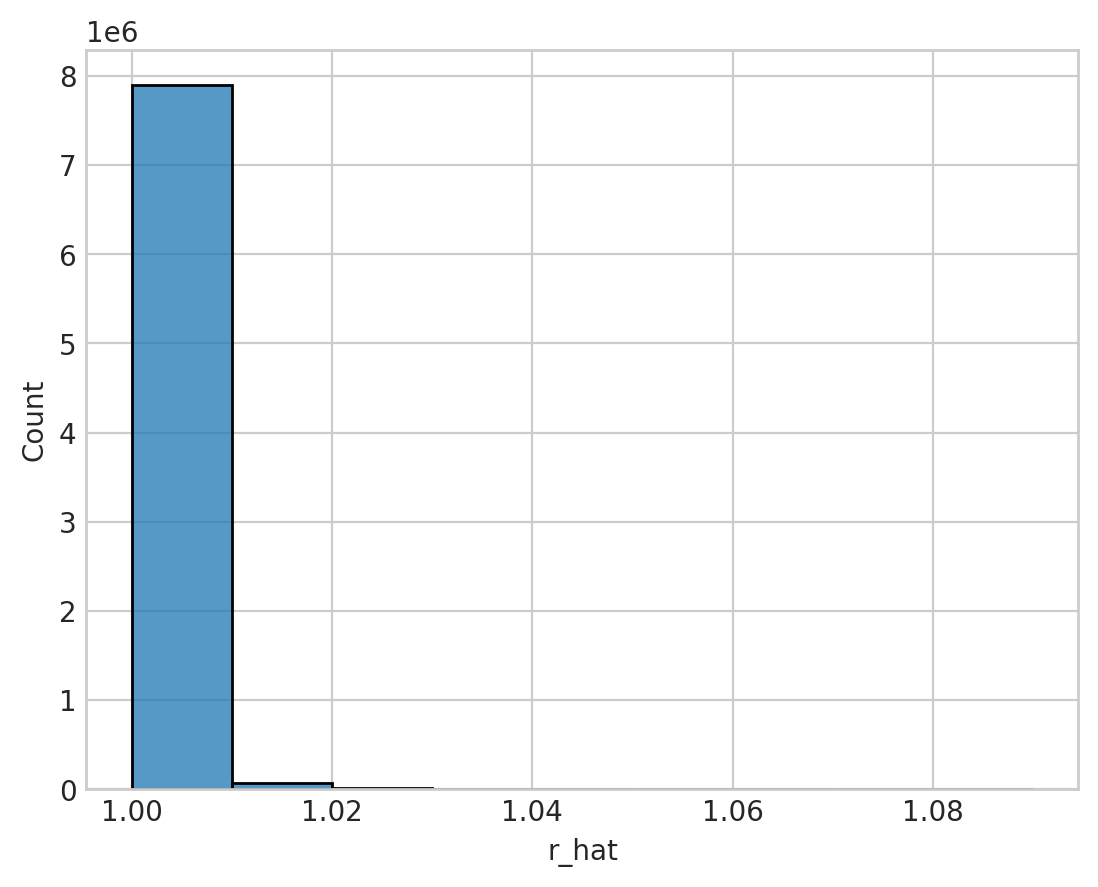

In [10]:
sns.histplot(data=var_diagnostics, x="r_hat", binwidth=0.01)
plt.show()

In [11]:
rhat_cutoffs = 1.01, 1.03
for rhat_cutoff in rhat_cutoffs:
    frac_good_rhat = (var_diagnostics["r_hat"] <= rhat_cutoff).mean()
    print(f"fraction of variables with Rhat ≤ {rhat_cutoff}: {frac_good_rhat}")

fraction of variables with Rhat ≤ 1.01: 0.9990174045250586
fraction of variables with Rhat ≤ 1.03: 0.9999942281455948


In [12]:
var_diagnostics.query("r_hat > 1.03").count()

parameter          46
ess_bulk           46
ess_tail           46
r_hat              46
var_name           46
lineage_subtype    46
dtype: int64

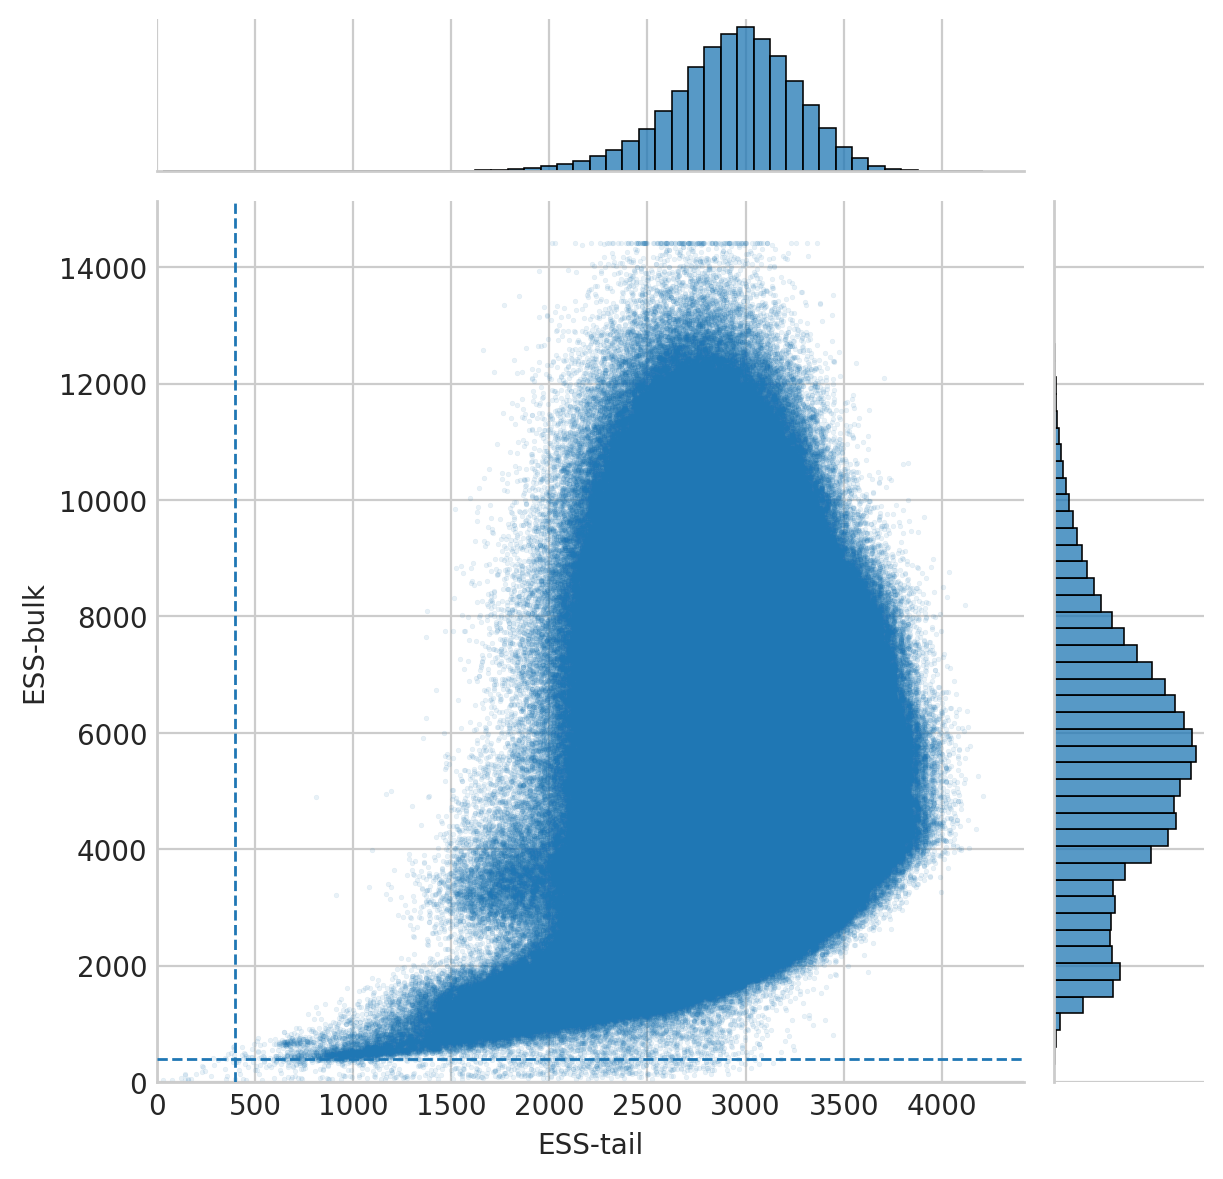

In [13]:
jp = sns.jointplot(
    data=var_diagnostics,
    x="ess_tail",
    y="ess_bulk",
    joint_kws={"edgecolor": None, "s": 3, "alpha": 0.1, "color": "tab:blue"},
    marginal_kws={"bins": 50},
)
ax = jp.ax_joint
ax.set_xlim(0, None)
ax.set_ylim(0, None)

ax.axhline(400, color="tab:blue", lw=1, ls="--", zorder=10)
ax.axvline(400, color="tab:blue", lw=1, ls="--", zorder=10)
ax.set_xlabel("ESS-tail")
ax.set_ylabel("ESS-bulk")

plt.show()

In [14]:
var_diagnostics[["lineage_subtype", "ess_tail", "ess_bulk"]].groupby(
    "lineage_subtype"
).describe().round(2)

ess_tail                           \
                                              count     mean     std     min   
lineage_subtype                                                                
bile duct (cholangiocarcinoma)             163145.0  2810.15  330.67   682.0   
bile duct (gallbladder adenocarcinoma)     143826.0  2984.86  331.80  1028.0   
blood (ALL)                                343567.0  2918.35  310.78    33.0   
blood (AML)                                199095.0  2917.31  266.10   878.0   
blood (CLL)                                143730.0  3052.69  231.83  1003.0   
blood (CML)                                143874.0  3034.13  276.63  1306.0   
bone (Ewing sarcoma)                       144306.0  2884.54  266.75  1511.0   
bone (chordoma)                            143730.0  2780.49  412.25   605.0   
bone (osteosarcoma)                        143970.0  2994.60  277.19   993.0   
breast                                     235957.0  2787.86  313.43   732.0   
central nervous system (glioma)            327176.0  2895.10  355.55   631.0   
central nervous system (medulloblastoma)   161993.0  2992.81  316.62  1338.0   
cervix (cervical carcinoma)                143778.0  3005.82  293.25  1255.0   
cervix (cervical squamous)                 143778.0  3044.51  264.30   921.0   
colorectal                                 236053.0  2981.38  311.94   423.0   
esophagus (esophagus adenocarcinoma)       143778.0  3009.11  305.32  1042.0   
esophagus (esophagus squamous)             162617.0  2850.95  273.01  1226.0   
eye (uveal melanoma)                       143778.0  3106.80  272.14  1493.0   
gastric (gastric adenocarcinoma)           253596.0  2986.30  262.04  1121.0   
kidney (renal cell carcinoma)              235285.0  2994.43  339.21   978.0   
liver (hepatocellular carcinoma)           162617.0  2851.37  265.96  1090.0   
lung (NSCLC)                               328712.0  2780.89  357.40   492.0   
lung (SCLC)                                180688.0  3026.89  328.34   906.0   
lung (mesothelioma)                        144162.0  2968.80  289.24  1203.0   
lymphocyte (hodgkin lymphoma)              143730.0  3063.63  264.67  1652.0   
lymphocyte (lymphoma unspecified)          143778.0  3001.92  250.29  1157.0   
lymphocyte (non hodgkin lymphoma)          144498.0  2697.66  357.69    76.0   
ovary (ovary adenocarcinoma)               254268.0  2823.14  312.58   664.0   
pancreas                                   235957.0  2965.22  391.94   608.0   
peripheral nervous system (neuroblastoma)  162617.0  2911.21  318.39  1023.0   
plasma cell (multiple myeloma)             144546.0  2852.68  332.49   518.0   
prostate                                   143778.0  2991.99  321.64   711.0   
skin (melanoma)                            327464.0  2943.99  340.31   661.0   
skin (skin squamous)                       143730.0  2980.19  273.27  1360.0   
soft tissue (ATRT)                         143778.0  3079.34  263.54   735.0   
soft tissue (liposarcoma)                  143874.0  3013.59  303.02   767.0   
soft tissue (malignant rhabdoid tumor)     143922.0  3005.15  266.56  1067.0   
soft tissue (rhabdomyosarcoma)             144018.0  2965.07  322.54   453.0   
soft tissue (synovial sarcoma)             143778.0  3024.88  278.01  1386.0   
thyroid (thyroid carcinoma)                143970.0  2926.74  299.92   712.0   
upper aerodigestive                        145746.0  2735.45  262.11  1609.0   
urinary tract                              181216.0  2780.30  394.08   659.0   
uterus (endometrial adenocarcinoma)        361830.0  2905.56  325.11   353.0   

                                                                            \
                                              25%     50%      75%     max   
lineage_subtype                                                              
bile duct (cholangiocarcinoma)             2603.0  2787.0  2991.00  4015.0   
bile duct (gallbladder adenocarcinoma)     2759.0 

In [15]:
def get_bfmi(pm: PostDataMan, stash: bool = True) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"bfmi_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    bfmi = az.bfmi(pm.trace)
    res = pd.DataFrame({"lineage_subtype": pm.id, "bfmi": bfmi})
    res.to_csv(stash_fp, index=False)
    return res


def get_num_divergences(pm: PostDataMan, stash: bool = True) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"divergences_{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    n_divs = pm.trace.sample_stats.diverging.sum(dim="draw").values
    res = pd.DataFrame(
        {
            "lineage_subtype": pm.id,
            "n_divergences": n_divs,
            "n_draws": pm.trace.posterior.dims["draw"],
        }
    )
    res.to_csv(stash_fp, index=False)
    return res

In [16]:
posterior_bfmis = pd.concat([get_bfmi(pm) for pm in postmen.posteriors]).reset_index(
    drop=True
)
posterior_bfmis.head()

,lineage_subtype,bfmi
0,bile duct (cholangiocarcinoma),0.723258
1,bile duct (cholangiocarcinoma),0.770877
2,bile duct (cholangiocarcinoma),0.822700
3,bile duct (cholangiocarcinoma),0.753306
4,bile duct (gallbladder adenocarcinoma),0.642570


In [17]:
posterior_divs = pd.concat(
    [get_num_divergences(pm) for pm in postmen.posteriors]
).reset_index(drop=True)
posterior_divs.head()

,lineage_subtype,n_divergences,n_draws
0,bile duct (cholangiocarcinoma),0,1000
1,bile duct (cholangiocarcinoma),0,1000
2,bile duct (cholangiocarcinoma),0,1000
3,bile duct (cholangiocarcinoma),0,1000
4,bile duct (gallbladder adenocarcinoma),0,1000


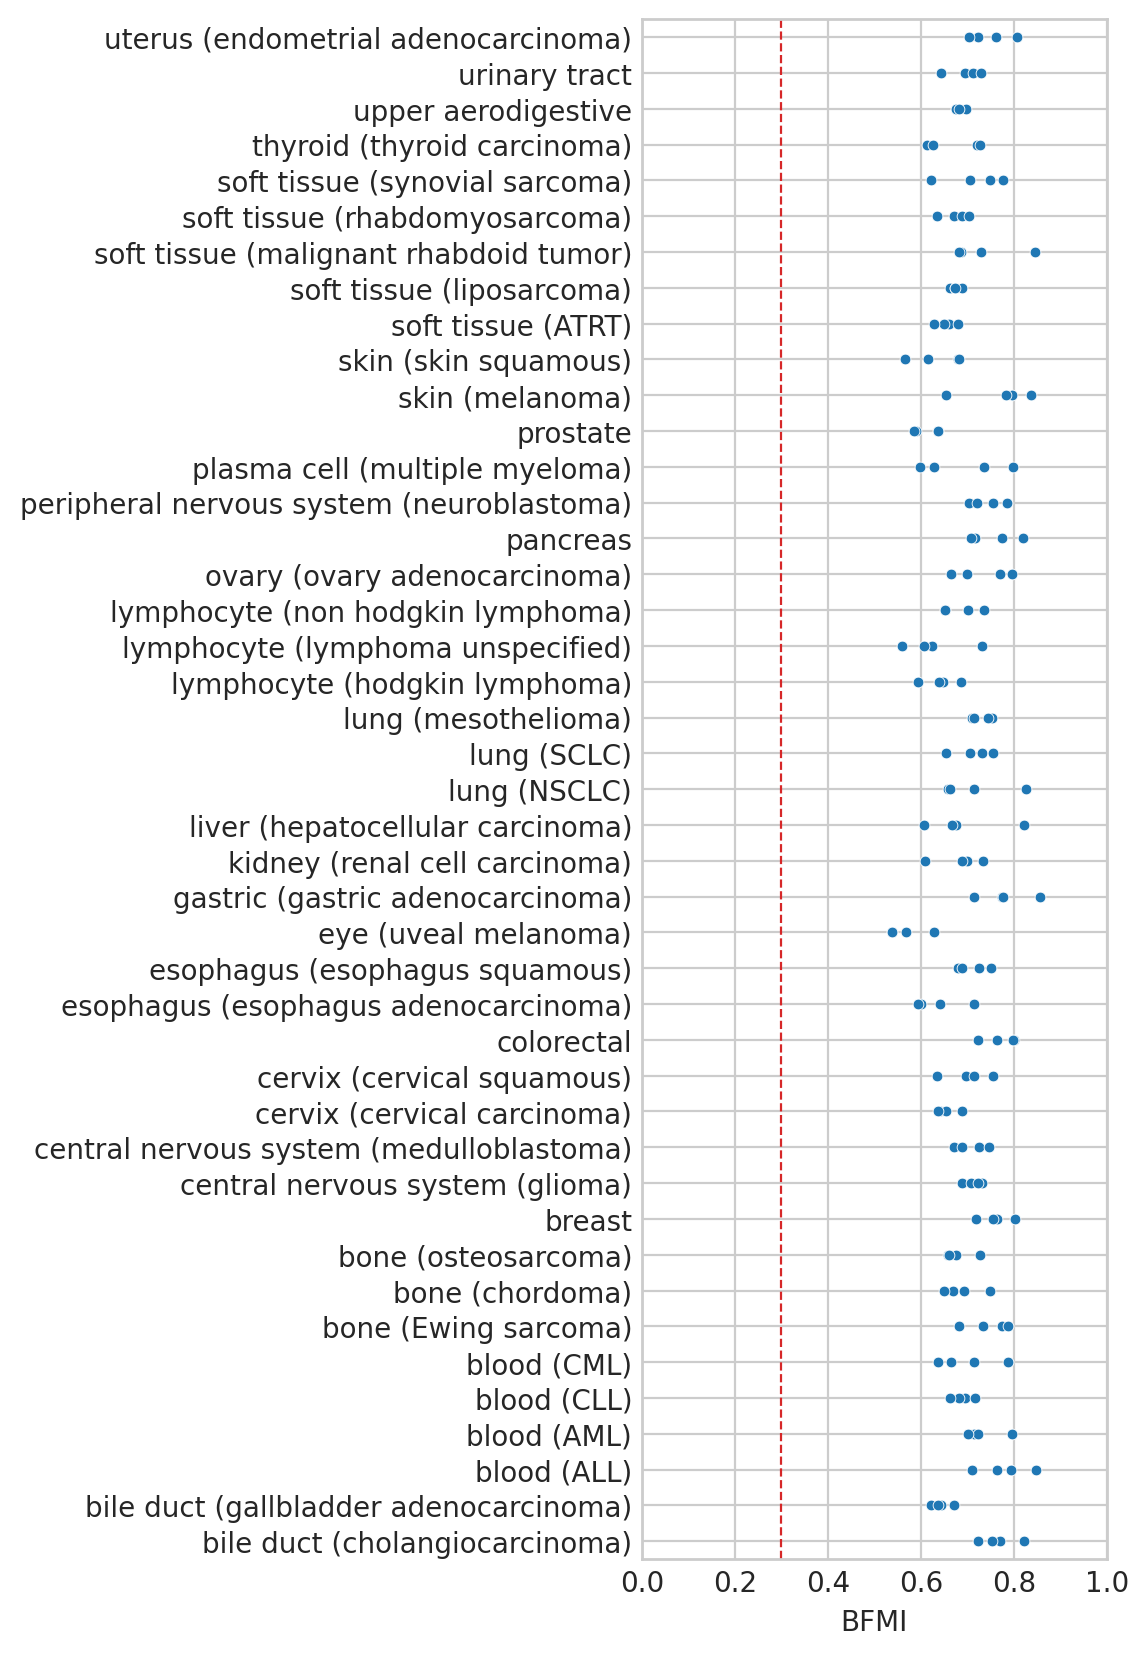

In [18]:
_, ax = plt.subplots(figsize=(3, 10))
sns.scatterplot(
    data=posterior_bfmis, x="bfmi", y="lineage_subtype", ax=ax, s=15, color="tab:blue"
)
ax.set_ylim(-0.5, posterior_bfmis["lineage_subtype"].nunique() - 0.5)
ax.set_xlabel("BFMI")
ax.set_ylabel(None)
ax.set_xlim(0, 1)
ax.axvline(0.3, lw=0.8, ls="--", color="tab:red")
plt.show()

In [19]:
posterior_divs.query("n_divergences > 0")

,lineage_subtype,n_divergences,n_draws


---

In [20]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.73 minutes


In [21]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-12

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-17-85.o2.rc.hms.harvard.edu

Git branch: figures

arviz     : 0.12.1
numpy     : 1.23.3
matplotlib: 3.5.3
pandas    : 1.4.4
seaborn   : 0.11.2

